# Exponential Smoothing Models:

##### Exponential smoothing models are methods for forecasting time series data based on weighted averages of the past observations.
* Exponential smoothing was proposed by;
    * [Brown, R. G. (1959)](https://www.worldcat.org/title/statistical-forecasting-for-inventory-control/oclc/573848798)
    * [Holt, C. C. (1957)](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134?via%3Dihub)
    * [Winters, P. R. (1960)](https://pubsonline.informs.org/doi/10.1287/mnsc.6.3.324)

##### The exponential smoothing methods generally use;
* Level
* Trend
* Seasonal

components for generating forecasts. These components and their calculations vary based on the method used.

In [1]:
#Import pandas for loading a time series dataframe and matplotlib for some plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the Monthly Temperatures Data
#https://datahub.io/core/global-temp#data
df = pd.read_csv("/home/hasan/Desktop/Codes/yzt_main/datasets/monthly_temp.csv", index_col=0)
df

,GCAG Mean Temp,GISTEMP Mean Temp
2016-12-06,0.7895,0.81
2016-11-06,0.7504,0.93
2016-10-06,0.7292,0.89
2016-09-06,0.8767,0.87
2016-08-06,0.8998,0.98
...,...,...
1880-05-06,-0.0738,-0.14
1880-04-06,-0.0499,-0.27
1880-03-06,-0.1357,-0.18
1880-02-06,-0.1229,-0.21


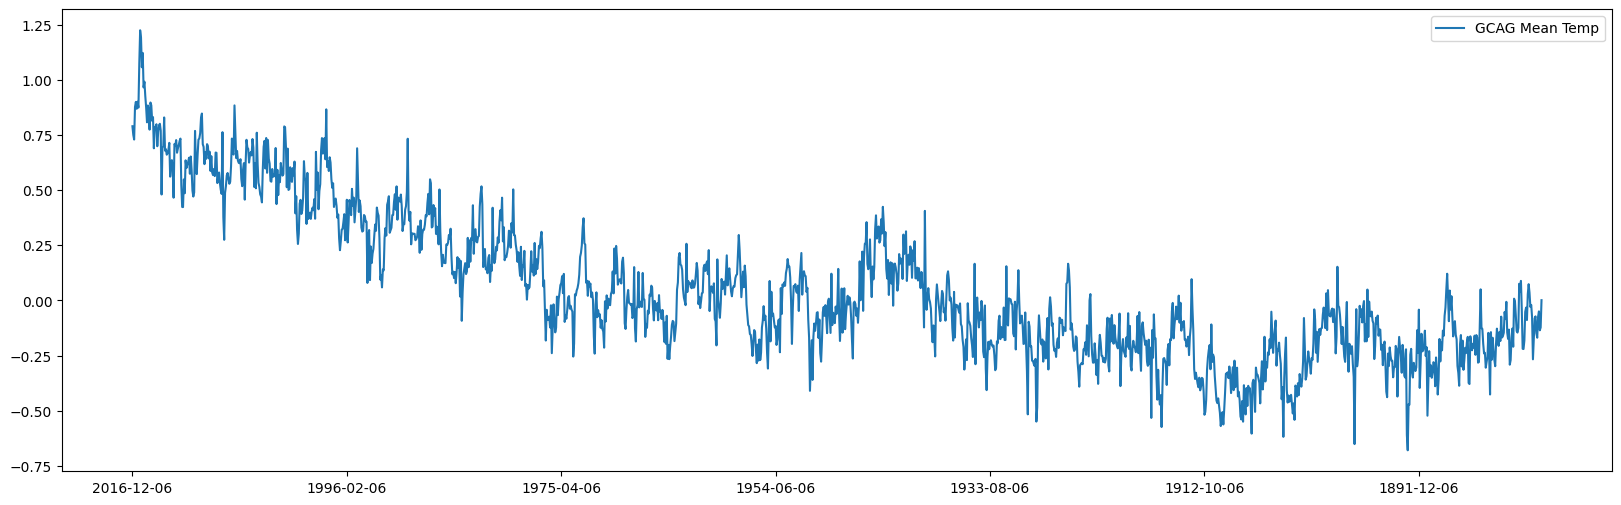

In [3]:
#As exponential smoothing methods expect univariate data, we will take the GCAG measurements only
df = df[["GCAG Mean Temp"]].copy()
#Plot to visualize the time series data
df.plot(figsize=(20,6))
plt.show()

In [4]:
#Import the exponential smoothing module from chronokit
from chronokit import exponential_smoothing

### Smoothing Models

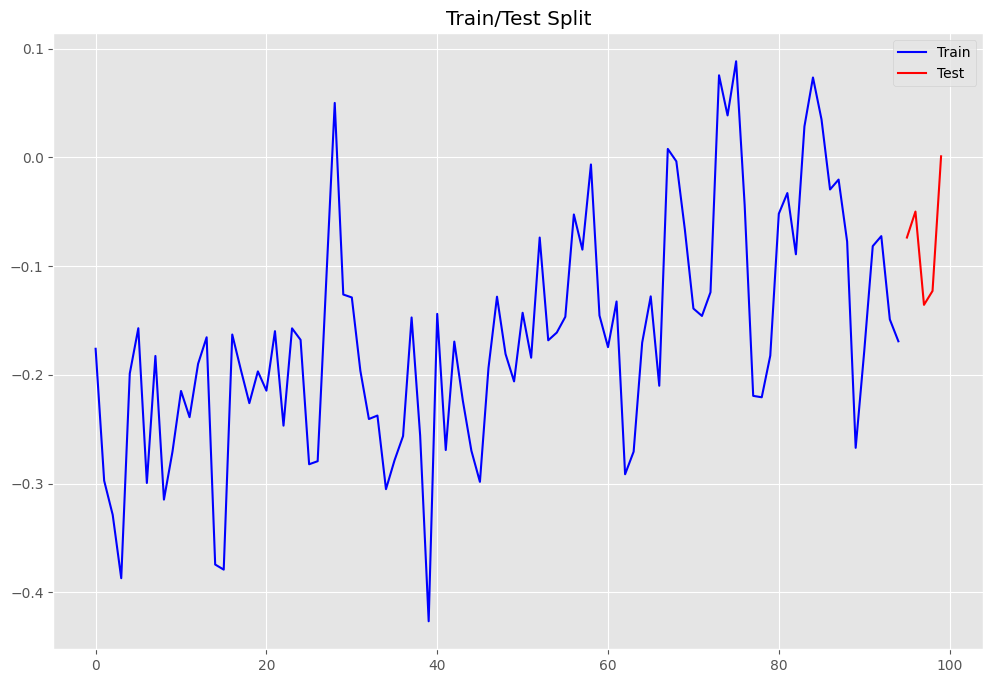

In [5]:
#Before fitting the models, split the data into training and testing;
#We will take the last 5 months of data to test the results of the models
df_train = df.iloc[:-5]
df_test = df.iloc[-5:]

#Plot the data by calling plot_train_test_split() function from chronokit.utils module
from chronokit.utils import plot_train_test_split
#Take a smaller part of the training data to visualize the test data better
plot_train_test_split(train_data=df_train[-95:], test_data=df_test, colors=["blue", "red"], style="ggplot", title="Train/Test Split")

In [6]:
#Initialize the smoothing model
#Trend and seasonal arguments correspond to method of calculation for the respective components
#Different combinations of methods can be tried out to get better results
smoothing_model = exponential_smoothing.ExponentialSmoothing(data=df_train, trend="add", seasonal="add", seasonal_periods=12)

In [7]:
#Fit the smoothing model to the training data by calling .fit()
smoothing_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
fc = smoothing_model.predict(h=5)

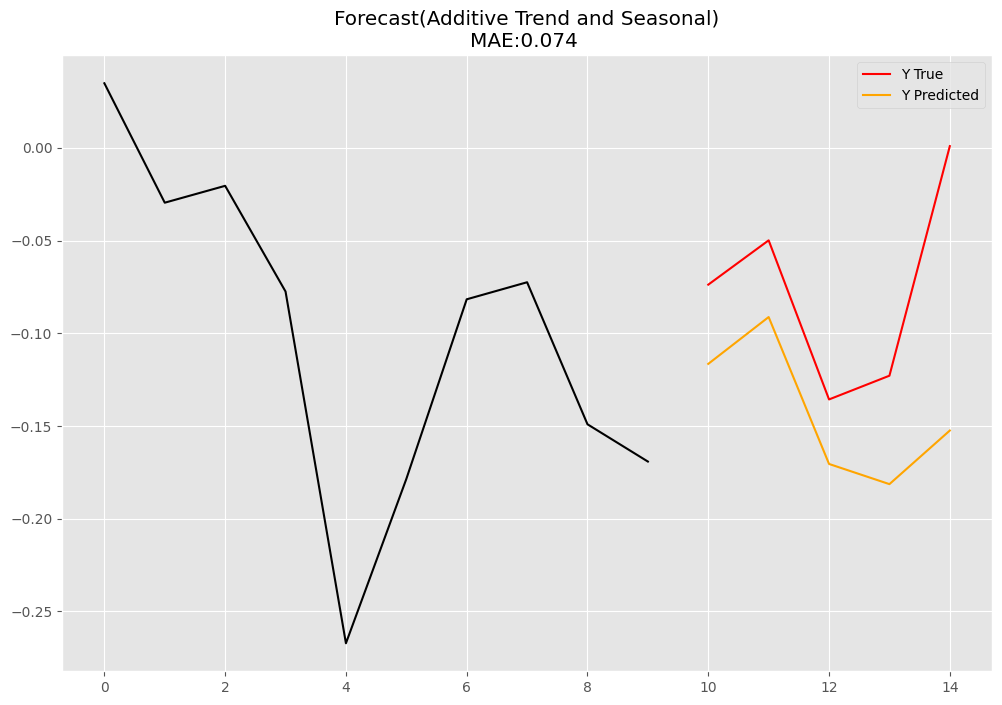

In [8]:
#Visualize the results by calling plot_predictions() from chronokit.utils module

from chronokit.utils import plot_predictions

#Provide the last 10 months of training data as pre_vals for a better visuals
#Provide metrics argument(as a list) to see the resulting metrics on the title
plot_predictions(y_true=df_test, y_pred=fc, pre_vals=df_train[-10:], colors=["red", "orange"], title="Forecast(Additive Trend and Seasonal)", metrics=["mae"])

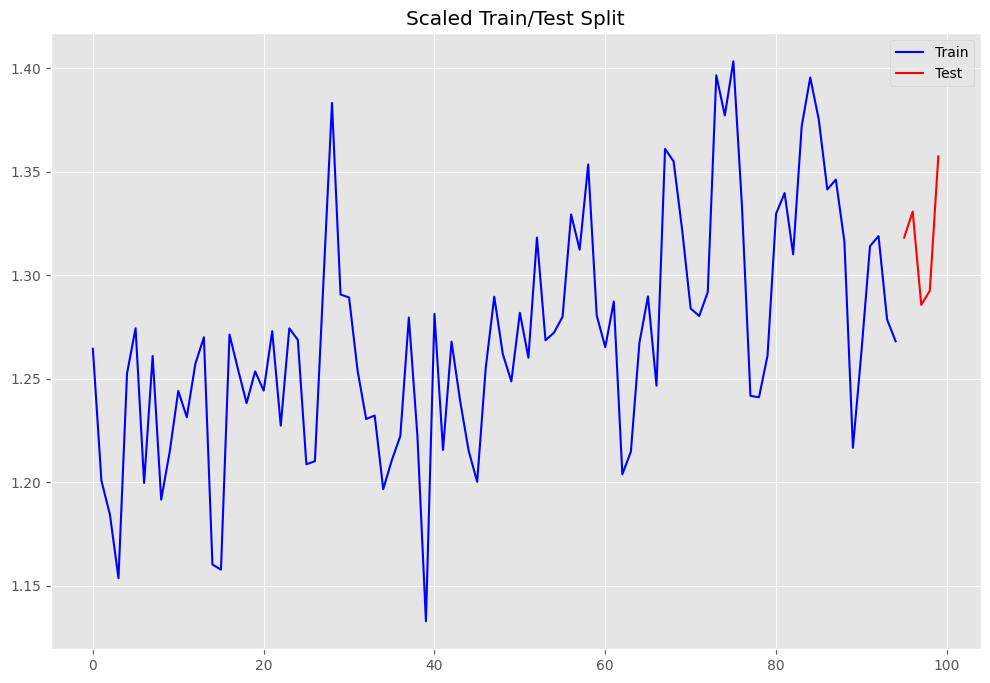

In [9]:
#Let's try multiplicative seasonality to see if we can get better results
#However, models with multiplicative seasonality requires strictly positive data
#We can scale our data to be strictly positive by the chronokit.preprocessing module

from chronokit.preprocessing import MinMaxScaling

#Provide feature range as (1,2) to ensure strict positiveness
scaler = MinMaxScaling(feature_range=(1,2))

#Scale the training data first
scaled_tr = scaler.transform(df_train)
#Then scale the test data with the same min and max parameters obtained from the training data
scaled_test = scaler.transform(df_test, mins=scaler.mins, maxes=scaler.maxes)

plot_train_test_split(train_data=scaled_tr[-95:], test_data=scaled_test, colors=["blue", "red"], style="ggplot", title="Scaled Train/Test Split")

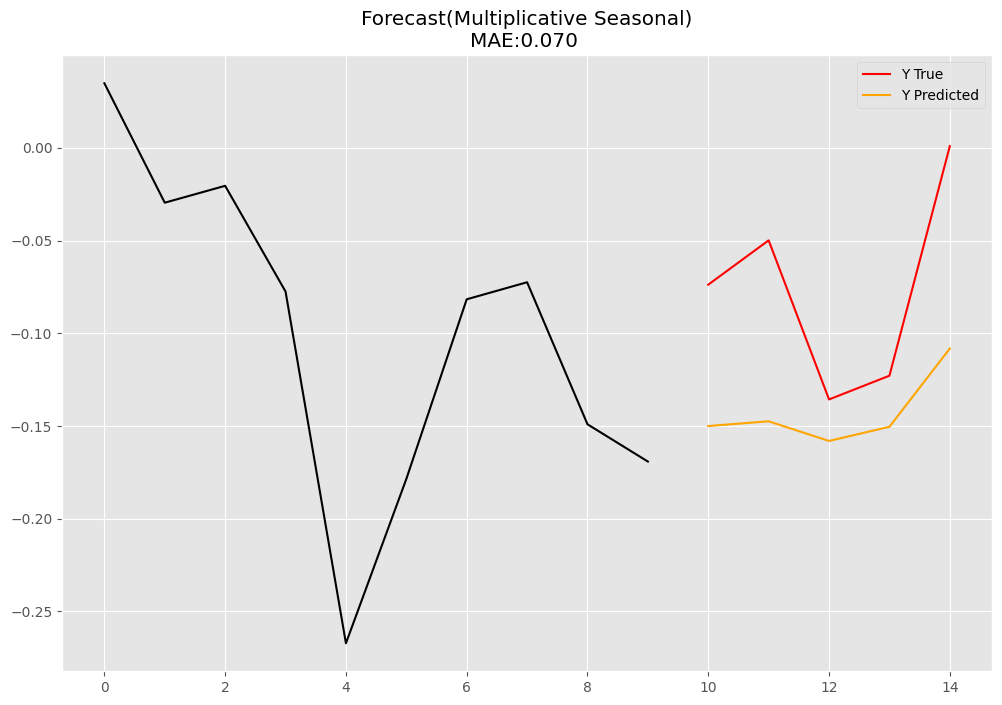

In [10]:
#Now, let's see how the multiplicative seasonality performs
smoothing_model = exponential_smoothing.ExponentialSmoothing(data=scaled_tr, trend="add", seasonal="mul", seasonal_periods=12)
smoothing_model.fit()
fc = smoothing_model.predict(h=5)

#Re-scale forecasts to obtain true values
true_fc = scaler.inverse_transform(fc)
#We see that the Mean Absolute Error is smaller, so the multiplicative seasonality leads to slighly better results
plot_predictions(y_true=df_test, y_pred=true_fc, pre_vals=df_train[-10:], colors=["red", "orange"], title="Forecast(Multiplicative Seasonal)", metrics=["mae"])

### ETS Models

##### ETS stands for Error-Trend-Seasonality and these types of models take the residuals generated during fitting into account when estimating components

In [11]:
#Initialize the ETS model
#Parameters are generally the same for smoothing models, with error_type added for calculations using the residuals
#Also, more combinations of trend and seasonality types are achievable by ETS methods
ets_model = exponential_smoothing.ETS(data=df_train, trend="add", seasonal="add", seasonal_periods=12, error_type="add")

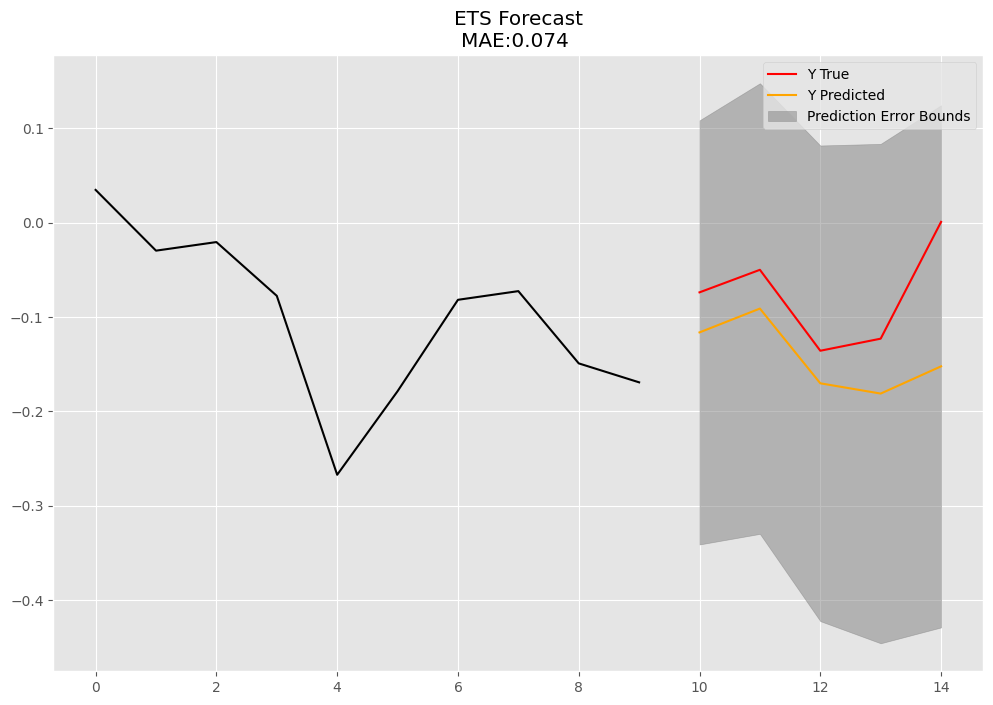

In [12]:
#Fit the smoothing model to the training data by calling .fit()
ets_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
#An advantage of ETS models is that a confidence interval can be generated
#Provide confidence=0.95 to get %95 confidence intervals
fc, bounds = ets_model.predict(h=5, confidence=0.95)

#Plot the forecasts together with the confidence interval
plot_predictions(y_true=df_test, y_pred=fc, bounds=bounds, pre_vals=df_train[-10:], bounds_fill_alpha=0.5, 
                 colors=["red", "orange"], title="ETS Forecast", metrics=["mae"])

### Model Selection

The model selection process applies information criterions to estimate the best fitting model for the given data

In [13]:
#Import the model_selection() function
from chronokit.preprocessing import model_selection 

In [14]:
#Provide the scaled data to also include multiplicative seasonality models
#Provide model="smoothing" to compare exponential smoothing models

#Get the selection results and the recommended parameters
results, params = model_selection(data=scaled_tr, model="smoothing", criterion="aic", seasonal_periods=12)

#Lower values imply better results
results

{'ETS_ANN, damped=True': -29.422508539173577,
 'ETS_ANN, damped=False': -31.422508539173577,
 'ETS_ANA, damped=True': -27.301245060604543,
 'ETS_ANA, damped=False': -29.301245060604543,
 'ETS_AAN, damped=True': -27.419035077254193,
 'ETS_AAN, damped=False': -29.370312740998372,
 'ETS_AAA, damped=True': -25.30104751782936,
 'ETS_AAA, damped=False': -27.296680633393592,
 'ETS_MNN, damped=True': -29.42408345427735,
 'ETS_MNN, damped=False': -31.42408345427735,
 'ETS_MNA, damped=True': -27.301245060604543,
 'ETS_MNA, damped=False': -29.301245060604543,
 'ETS_MAN, damped=True': -27.42129269381781,
 'ETS_MAN, damped=False': -29.35627798564581,
 'ETS_MAA, damped=True': -25.29812403264578,
 'ETS_MAA, damped=False': -27.293529092305718,
 'SES, damped=True': -29.422508567534422,
 'SES, damped=False': -31.422508567534422,
 'HoltTrend, damped=True': -27.422349762614566,
 'HoltTrend, damped=False': -29.370496060527834,
 'HoltWinters, damped=True': -25.30127160456609,
 'HoltWinters, damped=False': -

In [15]:
print(params)
#These parameters corresponds to an ETS model with only multipicative errors and no trend/seasonality

{'trend': None, 'seasonal': None, 'damped': False, 'error': 'mul'}


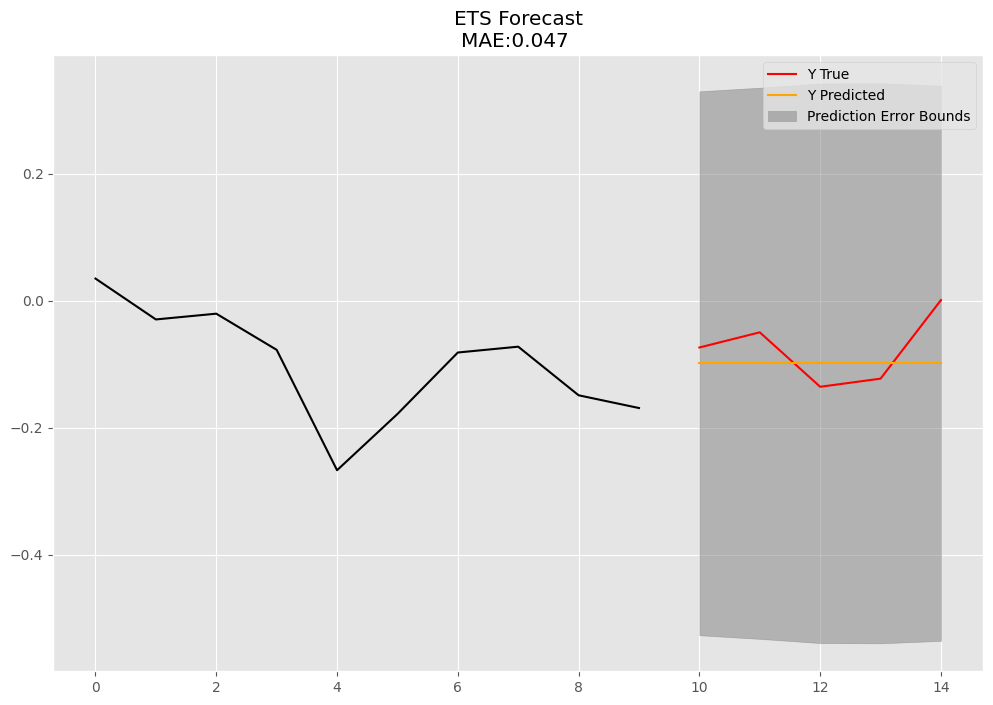

In [16]:
#Fit the ETS model
best_ets = exponential_smoothing.ETS(data=df_train, error_type="mul", trend=None, seasonal=None)
best_ets.fit()

#Get the forecasts along with the interval
fc, bounds = best_ets.predict(5, confidence=0.95)

#As we can see, it performs better than the previously tried model
#Although the forecast is simply a straight line, it proves to be an effective forecast of the future values
plot_predictions(y_true=df_test, y_pred=fc, bounds=bounds, pre_vals=df_train[-10:], bounds_fill_alpha=0.5, 
                 colors=["red", "orange"], title="ETS Forecast", metrics=["mae"])